# MLOps Testing
## Credit Risk Classification — Analysis of the South German Credit Dataset




#Imports

In [1]:
# =============================================================
# Import-capture robusto + listado SOLO de lo que importas tú
# =============================================================
import builtins, sys
from importlib import import_module
from importlib.metadata import packages_distributions, version, PackageNotFoundError

_CAPTURE_ACTIVE = False
_CAPTURED = set()
_ORIG_IMPORT = builtins.__import__

# alias útiles módulo -> distribución PyPI
_ALIAS = {
    "sklearn": "scikit-learn",
    "PIL": "Pillow",
}

# Ruido típico de IPython/Jupyter que no queremos
_IGNORE = {
    "IPython","matplotlib_inline","jupyter","jupyter_core","jupyter_client",
    "ipykernel","traitlets","prompt_toolkit","pygments","pexpect","pickleshare",
    "debugpy","parso","wcwidth","ptyprocess","backcall","decorator"
}

def _import_hook(name, globals=None, locals=None, fromlist=(), level=0):
    if _CAPTURE_ACTIVE:
        top = name.split('.')[0]
        # evita stdlib y ruido
        if hasattr(sys, "stdlib_module_names"):
            is_std = top in sys.stdlib_module_names
        else:
            # fallback muy simple para entornos sin stdlib_module_names
            is_std = top in {"sys", "os", "json", "re", "math", "time", "itertools", "functools"}
        if (not is_std) and (top not in _IGNORE):
            _CAPTURED.add(top)
    return _ORIG_IMPORT(name, globals, locals, fromlist, level)

def start_import_capture(reset=True):
    """Activa el hook de importación. Usa reset=True para limpiar capturas previas."""
    global _CAPTURE_ACTIVE, _CAPTURED
    if reset:
        _CAPTURED = set()
    builtins.__import__ = _import_hook
    _CAPTURE_ACTIVE = True
    print("✅ Import capture STARTED")

def stop_import_capture(show_requirements=True, include_deps=False):
    """Desactiva el hook y opcionalmente imprime requirements.
       include_deps=False -> solo los módulos que TÚ importaste explícitamente.
       include_deps=True  -> intenta resolver distribuciones PyPI (puede añadir dependencias)."""
    global _CAPTURE_ACTIVE
    builtins.__import__ = _ORIG_IMPORT
    _CAPTURE_ACTIVE = False
    print("🛑 Import capture STOPPED")
    if show_requirements:
        print("\n============================================")
        print("🔹 IMPORTED PACKAGES (requirements format)")
        print("============================================")
        _print_requirements(include_deps=include_deps)

def _safe_print_line(name, ver):
    if name and str(name).strip() and ver and str(ver).strip():
        print(f"{name}=={ver}")

def _print_requirements(include_deps=False):
    """Si include_deps=False: intenta __version__ del módulo (solo lo que importaste).
       Si include_deps=True: resuelve distribución con importlib.metadata (más ruidoso)."""
    mapping = packages_distributions()

    seen = set()
    for mod in sorted(_CAPTURED):
        if mod in seen:
            continue

        # 1) Solo lo importado explícito (recomendado: include_deps=False)
        if not include_deps:
            try:
                m = import_module(mod)
                ver = getattr(m, "__version__", None)
                # algunos modulos usan nombres distintos para la distribución
                dist_name = _ALIAS.get(mod, mod)
                if ver:
                    _safe_print_line(dist_name, ver)
                    seen.add(mod)
                # si no tiene __version__, lo omitimos (evita ValueError)
            except Exception:
                pass
            continue

        # 2) Modo dependencias: resolver distribución PyPI
        dist_names = mapping.get(mod, [])
        dist = _ALIAS.get(mod) or (dist_names[0] if dist_names else mod)

        # evitar nombres vacíos que causan ValueError
        if not dist or not str(dist).strip():
            continue

        try:
            ver = version(dist)
            _safe_print_line(dist, ver)
            seen.add(mod)
        except PackageNotFoundError:
            # intento final con el nombre del módulo
            try:
                ver = version(mod)
                _safe_print_line(mod, ver)
                seen.add(mod)
            except PackageNotFoundError:
                pass


In [2]:
start_import_capture()

✅ Import capture STARTED


In [3]:
# =============================================================
# Instalar dependencias necesarias
# =============================================================
!pip install -q mlflow google-cloud-storage category_encoders imbalanced-learn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.6/752.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 7.7 MB/s eta 0:00:00


In [4]:
# =============================================================
# Future features
# =============================================================
from __future__ import annotations

# =============================================================
# Standard library
# =============================================================
import os
import sys
import re
import json
import warnings
import tempfile

# =============================================================
# Colab integration
# =============================================================
from google.colab import userdata, drive, auth  # noqa

# =============================================================
# Core scientific stack
# =============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================
# Scikit-learn: base, preprocessing, pipelines, model selection, metrics
# =============================================================
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_validate,
    cross_val_predict,
    GridSearchCV,
)

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)

# =============================================================
# Imbalanced-learn
# =============================================================
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.metrics import geometric_mean_score

# =============================================================
# Models
# =============================================================
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# =============================================================
# Encoders & utilities
# =============================================================
import category_encoders as ce

# =============================================================
# MLflow & GCP
# =============================================================
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models import infer_signature
from google.cloud import storage



# ============================================
# IMPORTS para los 7 modelos
# ============================================
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier



# =============================================================
# Global config
# =============================================================
RANDOM_STATE = 5
np.set_printoptions(suppress=True)
pd.set_option("display.max_colwidth", 120)
GMEAN_SCORER = make_scorer(geometric_mean_score)

# silence common warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [5]:
# =============================================================
# 1) Autenticación y configuración inicial en Google Cloud + Drive
# =============================================================

# -------------------------------------------------------------
# 1.1) Autenticación manual en GCP (si el servicio MLflow lo requiere)
# -------------------------------------------------------------
# Este paso abre una ventana emergente para iniciar sesión con tu cuenta de Google.
!gcloud auth login

# -------------------------------------------------------------
# 1.2) Autenticación con Google Cloud desde Colab
# -------------------------------------------------------------
# Permite a Colab acceder a los servicios de Google Cloud (como Cloud Storage).
auth.authenticate_user()
print("✅ Autenticación con Google Cloud completada correctamente.")

# -------------------------------------------------------------
# 1.3) Montar Google Drive y acceder a la carpeta compartida
# -------------------------------------------------------------

drive.mount('/content/drive', force_remount=True)

FOLDER_ID = userdata.get('FOLDER_ID')
if not FOLDER_ID:
    raise ValueError("❌ FOLDER_ID not found. Define it in Colab > Variables de entorno.")

TARGET = f"/content/drive/.shortcut-targets-by-id/{FOLDER_ID}"
os.chdir(TARGET)


Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=gdZVgqkENohVnAuigvvISA70Ef1Iw0&prompt=consent&token_usage=remote&access_type=offline&code_challenge=OgE2k4QDqVZ9dRGRa9As4aSUq8Sn9cQseNH-rnNqtBQ&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0Ab32j92VSljjnu27KMc2TBVSt1roB5lJPF_m198kI9wT-tli0u5mQJF02MMVtJZXj2HBLA

You are now logged in as [a00939669@tec.mx].
Your current project is [N

#Configuracion Datos


In [6]:
# =============================================================
# 1) Importar listas de columnas desde config.py
# =============================================================
sys.path.append(os.path.join(TARGET, "trabajo_grupal_mlops", "Notebooks"))
from config import num_col, ord_col, cat_col

In [7]:
# =============================================================
# 2) Cargar parquet y preparar DataFrame
# =============================================================
parquet_path = os.path.join(TARGET, "trabajo_grupal_mlops", "data", "03_df_eda_01.parquet")
df = pd.read_parquet(parquet_path)

df = df.apply(pd.to_numeric).astype("int64")

# Invertir la clase objetivo (1->0 y 0->1)
if 'credit_risk' not in df.columns:
    raise KeyError("La columna 'credit_risk' no existe en el DataFrame.")
df['credit_risk'] = df['credit_risk'].apply(lambda x: 0 if x == 1 else 1)

print("Dataset shape:", df.shape)
print(df['credit_risk'].value_counts())


Dataset shape: (992, 21)
credit_risk
0    689
1    303
Name: count, dtype: int64


In [8]:
# =============================================================
# 3) Split de datos
# =============================================================
X = df.drop(columns=['credit_risk'])
y = df['credit_risk']
RANDOM_STATE = 5

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

print("Dimensiones:")
print("  Entrenamiento:", Xtrain.shape, ytrain.shape)
print("  Prueba:", Xtest.shape, ytest.shape)

tmp_pos = (ytrain.sum() / ytrain.shape[0])
print(f"Distribución clases (train) -> Positiva: {tmp_pos*100:.2f}%, Negativa: {(1-tmp_pos)*100:.2f}%")

Dimensiones:
  Entrenamiento: (694, 20) (694,)
  Prueba: (298, 20) (298,)
Distribución clases (train) -> Positiva: 30.55%, Negativa: 69.45%


In [9]:
# =============================================================
# 4) Wrapper para BinaryEncoder (compatible con ColumnTransformer)
# =============================================================
class BinaryEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = ce.BinaryEncoder(cols=self.cols)
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=self.cols)
        self.encoder.fit(X_df)
        try:
            self.feature_names_out_ = self.encoder.get_feature_names_out()
        except AttributeError:
            self.feature_names_out_ = list(self.encoder.transform(X_df).columns)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.cols)
        return self.encoder.transform(X_df).to_numpy()

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [10]:
# =============================================================
# 5) Pipelines por tipo de variable
# =============================================================
numericas_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
])

nominales_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary_encoder', BinaryEncoderWrapper(cols=cat_col)),
])

ordinales_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder())
])

In [11]:
# =============================================================
# 6) ColumnTransformer unificado
# =============================================================
columnasTransformer = ColumnTransformer(
    transformers=[
        ('num', numericas_pipe, num_col),
        ('nom', nominales_pipe, cat_col),
        ('ord', ordinales_pipe, ord_col),
    ],
    verbose_feature_names_out=False,
    remainder='drop'
)

pre = columnasTransformer  # alias

In [12]:
# =============================================================
# 7) Verificación de dimensión tras preprocesamiento
# =============================================================
Xtmp = Xtrain.copy()
Xt = pre.fit_transform(Xtmp)
print("Dimensión entradas antes:", Xtmp.shape, " | después:", Xt.shape)

Dimensión entradas antes: (694, 20)  | después: (694, 37)


In [13]:
# =============================================================
# 8) Unificar conjuntos de entrenamiento y prueba para análisis global
# =============================================================
Xtraintest = pd.concat([Xtrain, Xtest], axis=0)
ytraintest = pd.concat([ytrain, ytest], axis=0)


# Resumen de modelos MLFlow



In [14]:
# =============================================================
# CONFIG + CHILD-RUN SELECTION (gate_passes=true)
# =============================================================
MLFLOW_TRACKING_URI = "https://mlflow-super-g57-137680020436.us-central1.run.app"
EXPERIMENT_NAME_OR_ID = "Experimento-Conexión-MLFlow-Grupo57"

RUN_NAME_WHITELIST = [
    "XGBoost + SMOTE v2__GRID",
    "RandomForest + SMOTE v2__GRID",
    "DecisionTree + SMOTE v2__GRID",
    "MLP + SMOTE v2__GRID",
    "SVC + SMOTE v2__GRID",
    "KNN + SMOTE v2__GRID",
    "LogReg + SMOTE v2__GRID",
]

# =============================================================
# Métricas preferidas: primero cv_cand_* (test→train), luego cv_best_*
# (si NO quieres cand_ comenta el bloque CAND_PREFERENCE y deja solo METRIC_PREFERENCE_BASE)
# =============================================================
METRIC_PREFERENCE_CAND = [
    "cv_cand_test_roc_auc",
    "cv_cand_test_f1",
    "cv_cand_test_recall",
    "cv_cand_test_precision",
    "cv_cand_test_accuracy",
    "cv_cand_train_roc_auc",
    "cv_cand_train_f1",
    "cv_cand_train_recall",
    "cv_cand_train_precision",
    "cv_cand_train_accuracy",
]
METRIC_PREFERENCE_BASE = [
    "cv_best_test_roc_auc",
    "cv_best_test_f1",
    "cv_best_test_recall",
    "cv_best_test_precision",
    "cv_best_test_accuracy",
    "cv_best_train_roc_auc",
    "cv_best_train_f1",
    "cv_best_train_recall",
    "cv_best_train_precision",
    "cv_best_train_accuracy",
]
METRIC_PREFERENCE = METRIC_PREFERENCE_CAND + METRIC_PREFERENCE_BASE

# =============================================================
# Setup & anti-Drive patch
# =============================================================
import os, mlflow, pandas as pd, numpy as np
from mlflow.tracking import MlflowClient

os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI
os.environ["MLFLOW_REGISTRY_URI"] = MLFLOW_TRACKING_URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Evitar errores por /content/drive en Colab
try:
    if os.getcwd().startswith("/content/drive"):
        os.chdir("/content")
except Exception:
    pass

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

try:
    exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME_OR_ID)
    EXPERIMENT_ID = exp.experiment_id if exp else str(EXPERIMENT_NAME_OR_ID)
except Exception:
    EXPERIMENT_ID = str(EXPERIMENT_NAME_OR_ID)

print(f"✅ Tracking URI: {mlflow.get_tracking_uri()}")
print(f"✅ Experiment: {EXPERIMENT_NAME_OR_ID} (id={EXPERIMENT_ID})")

# =============================================================
# Helper functions
# =============================================================
def _parse_bool_tag(val):
    if val is None:
        return False
    s = str(val).strip().lower()
    return s in {"true", "1", "yes", "y"}

def _params_from_dict(params: dict):
    if not params:
        return {}
    # preferimos lo que venga como "best::"
    best_like = {k.replace("best::", ""): v for k, v in params.items() if k.startswith("best::")}
    if best_like:
        return best_like
    # luego keys de modelo
    model_like = {k: v for k, v in params.items() if k.startswith("model__")}
    if model_like:
        return model_like
    # si no, todo el dict
    return params

def _params_to_str(d):
    if not d:
        return ""
    return ", ".join([f"{k}={d[k]}" for k in sorted(d.keys())])

def pick_best_metric_from_dict(metrics: dict):
    if not metrics:
        return None, None
    for m in METRIC_PREFERENCE:
        if m in metrics and metrics[m] is not None:
            try:
                return m, float(metrics[m])
            except Exception:
                continue
    return None, None

# =============================================================
# Retrieve all runs (parents + children)
# =============================================================
runs = client.search_runs(
    experiment_ids=[EXPERIMENT_ID],
    filter_string=None,
    max_results=10000
)

# --- separar padres e hijos de forma robusta ---
parent_candidates = []
child_records = []
for r in runs:
    tags = r.data.tags or {}
    run_name = tags.get("mlflow.runName", "")
    parent_id = tags.get("mlflow.parentRunId", None)
    if parent_id is None:
        parent_candidates.append(r)  # padres
    else:
        # hijos
        metrics = r.data.metrics or {}
        params = r.data.params or {}
        gate_raw = tags.get("gate_passes", tags.get("get_gates", None))
        gate_passes = _parse_bool_tag(gate_raw)
        child_records.append({
            "run_id": r.info.run_id,
            "parent_id": parent_id,
            "run_name": run_name,
            "metrics": metrics,
            "params": params,
            "tags": tags,
            "gate_passes": gate_passes,
        })

# --- mapear parent run_id → parent run_name, filtrando por whitelist ---
parent_map = {}
for pr in parent_candidates:
    pname = (pr.data.tags or {}).get("mlflow.runName", "")
    if pname in RUN_NAME_WHITELIST:
        parent_map[pr.info.run_id] = pname

runs_df = pd.DataFrame.from_records(child_records)

if runs_df.empty:
    print("⚠️ No child runs found for this experiment.")
    df_models = pd.DataFrame()
else:
    # asignar nombres de padre a los hijos; filtrar por whitelist
    runs_df["parent_name"] = runs_df["parent_id"].map(parent_map)
    runs_df = runs_df[runs_df["parent_name"].isin(RUN_NAME_WHITELIST)]

    if runs_df.empty:
        print("⚠️ No child runs belong to the listed parent names.")
        df_models = pd.DataFrame()
    else:
        best_rows = []
        failed_msgs = []

        for parent_name, g in runs_df.groupby("parent_name"):
            # sólo hijos que pasaron gates
            approved = g[g["gate_passes"] == True].copy()

            if approved.empty:
                # Si ninguno pasa gates, dejamos constancia y seguimos
                ref = None
                best_val = -np.inf
                for _, row in g.iterrows():
                    mname, mval = pick_best_metric_from_dict(row["metrics"])
                    if mval is not None and mval > best_val:
                        ref, best_val = row, mval
                ref_params = _params_from_dict(ref["params"]) if ref is not None else {}
                failed_msgs.append(
                    f"⚠️ {parent_name}: all children failed gates (under/overfit). "
                    f"Example params: {_params_to_str(ref_params)}"
                )
                continue

            # Selección del ganador por la primera métrica disponible
            winner = None
            chosen_metric_name, chosen_metric_value = None, None
            for m in METRIC_PREFERENCE:
                # recolectar candidatos con esa métrica
                candidates = []
                for _, row in approved.iterrows():
                    val = row["metrics"].get(m, None)
                    if val is not None:
                        try:
                            candidates.append((float(val), row))
                        except Exception:
                            pass
                if candidates:
                    candidates.sort(key=lambda x: x[0], reverse=True)
                    chosen_metric_value, winner = candidates[0]
                    chosen_metric_name = m
                    break

            # si nadie tiene la métrica preferida, toma el primero (debería ser raro)
            if winner is None:
                winner = approved.iloc[0]

            # params “bonitos”
            best_params = _params_from_dict(winner["params"])

            # aplanar métricas numéricas
            flat_metrics = {k: float(v) for k, v in (winner["metrics"] or {}).items() if v is not None}

            best_rows.append({
                "parent_name": parent_name,
                "child_run_id": winner["run_id"],
                "chosen_metric": chosen_metric_name,
                "metric_value": chosen_metric_value,
                "best_params": best_params,
                "best_params_str": _params_to_str(best_params),
                **flat_metrics,
            })

        df_models = pd.DataFrame(best_rows)

        # Advertencias por grupos sin aprobados
        for msg in failed_msgs:
            print(msg)

        # Ordenar: primero por nombre de métrica (mantener grupos) y luego por valor desc
        if not df_models.empty:
            df_models = df_models.sort_values(
                by=["chosen_metric", "metric_value"],
                ascending=[True, False],
                na_position="last"
            )

# =============================================================
# Display results
# =============================================================
pd.set_option("display.max_colwidth", None)
if not df_models.empty:
    base_cols = ["parent_name", "child_run_id", "chosen_metric", "metric_value", "best_params_str"]
    num_cols = [c for c in df_models.columns if c not in base_cols + ["best_params"] and pd.api.types.is_numeric_dtype(df_models[c])]
    display(df_models[base_cols + num_cols])
else:
    print("⚠️ No models with gate_passes=true found among child runs.")

# =============================================================
# Optional: Overall winner (by first available metric in METRIC_PREFERENCE)
# =============================================================
overall = None
if not df_models.empty:
    for m in METRIC_PREFERENCE:
        if m in df_models.columns and df_models[m].notna().any():
            overall = df_models.sort_values(m, ascending=False).iloc[0]
            print("\n🏆 Overall winner by", m)
            print(f"   • Parent model: {overall['parent_name']}")
            print(f"   • Child run ID: {overall['child_run_id']}")
            print(f"   • {m}: {overall[m]:.6f}")
            print(f"   • Params: {overall['best_params_str']}")
            break
    if overall is None:
        # fallback: por metric_value si existe
        if "metric_value" in df_models.columns and df_models["metric_value"].notna().any():
            overall = df_models.sort_values("metric_value", ascending=False).iloc[0]
            print("\n🏆 Overall winner by chosen_metric")
            print(f"   • Parent model: {overall['parent_name']}")
            print(f"   • Child run ID: {overall['child_run_id']}")
            print(f"   • {overall['chosen_metric']}: {overall['metric_value']:.6f}")
            print(f"   • Params: {overall['best_params_str']}")



✅ Tracking URI: https://mlflow-super-g57-137680020436.us-central1.run.app
✅ Experiment: Experimento-Conexión-MLFlow-Grupo57 (id=1)
⚠️ DecisionTree + SMOTE v2__GRID: all children failed gates (under/overfit). Example params: cand::model__class_weight=balanced, cand::model__criterion=gini, cand::model__max_depth=10, cand::model__max_features=None, cand::model__min_samples_leaf=4, cand::model__min_samples_split=10
⚠️ KNN + SMOTE v2__GRID: all children failed gates (under/overfit). Example params: cand::model__leaf_size=45, cand::model__n_neighbors=11, cand::model__p=1, cand::model__weights=distance
⚠️ RandomForest + SMOTE v2__GRID: all children failed gates (under/overfit). Example params: cand::model__class_weight=balanced, cand::model__max_depth=10, cand::model__max_features=None, cand::model__min_samples_leaf=1, cand::model__min_samples_split=2, cand::model__n_estimators=400
⚠️ XGBoost + SMOTE v2__GRID: all children failed gates (under/overfit). Example params: cand::model__colsample_b

,parent_name,child_run_id,chosen_metric,metric_value,best_params_str,cv_cand_test_f1,cv_cand_test_roc_auc,cv_cand_test_accuracy,cv_cand_test_precision,cv_cand_train_roc_auc,gate_gap_auc,gate_gap_f1,cv_cand_train_f1,cv_cand_test_recall,cv_cand_train_recall,cv_cand_train_accuracy,cv_cand_train_precision
0,LogReg + SMOTE v2__GRID,c8550fea89b941d697d954e31c99b847,cv_cand_test_roc_auc,0.773568,"cand::model__C=0.5, cand::model__class_weight=balanced, cand::model__penalty=l2",0.600649,0.773568,0.720781,0.532826,0.815515,0.041947,0.030765,0.631414,0.689454,0.740074,0.736137,0.550630
1,MLP + SMOTE v2__GRID,9e672477cf0948d0aa7bdb6752b31545,cv_cand_test_roc_auc,0.773291,"cand::model__activation=tanh, cand::model__alpha=0.001, cand::model__batch_size=128, cand::model__hidden_layer_sizes=(128,), cand::model__learning_rate_init=0.001",0.598244,0.773291,0.704629,0.514035,0.809149,0.035858,0.019801,0.618045,0.719126,0.744183,0.719004,0.529020
2,SVC + SMOTE v2__GRID,8951b5eab37548e0becb3053b20a5edb,cv_cand_test_roc_auc,0.767786,"cand::model__C=0.1, cand::model__class_weight=balanced, cand::model__gamma=0.1, cand::model__kernel=linear",0.593107,0.767786,0.700594,0.507003,0.810876,0.043090,0.027649,0.620756,0.715847,0.746655,0.721518,0.531447



🏆 Overall winner by cv_cand_test_roc_auc
   • Parent model: LogReg + SMOTE v2__GRID
   • Child run ID: c8550fea89b941d697d954e31c99b847
   • cv_cand_test_roc_auc: 0.773568
   • Params: cand::model__C=0.5, cand::model__class_weight=balanced, cand::model__penalty=l2


#GRAPH

[Info] N_NEG=689, N_POS=303, N_TOTAL=992


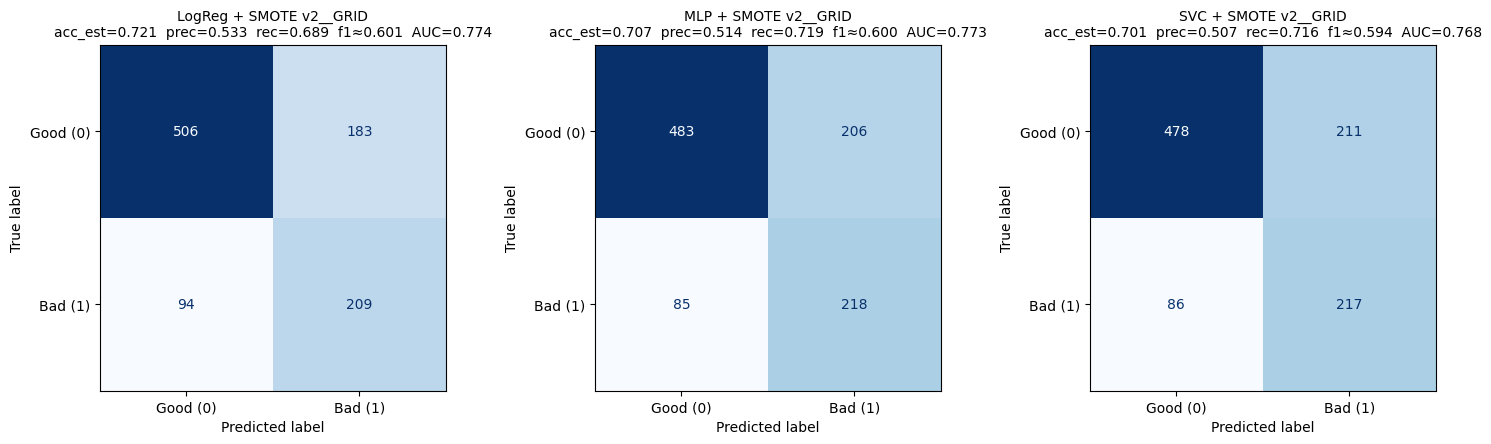

Estimated confusion matrices & checks:


,model_name,TN,FP,FN,TP,acc_est,acc_reported,precision_used,recall_used,f1_used,auc_used,f1_est
0,LogReg + SMOTE v2__GRID,506,183,94,209,0.721,0.721,0.533,0.689,0.601,0.774,0.601
1,MLP + SMOTE v2__GRID,483,206,85,218,0.707,0.705,0.514,0.719,0.598,0.773,0.600
2,SVC + SMOTE v2__GRID,478,211,86,217,0.701,0.701,0.507,0.716,0.593,0.768,0.594


In [15]:
# =============================================================
# 8) Estimar y graficar matrices de confusión desde df_models
#     Requiere:
#       - df con columna binaria 'credit_risk' (0=Good, 1=Bad)
#       - df_models con columnas tipo cv_cand_* o cv_best_* (test/train)
# =============================================================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# -------------------------------------------------------------
# Preferencia de métricas: primero "cand" (test→train), luego "best"
# -------------------------------------------------------------
METRIC_PREFERENCE = [
    # --- cand (TEST primero) ---
    "cv_cand_test_roc_auc", "cv_cand_test_f1", "cv_cand_test_recall",
    "cv_cand_test_precision", "cv_cand_test_accuracy",
    "cv_cand_train_roc_auc", "cv_cand_train_f1", "cv_cand_train_recall",
    "cv_cand_train_precision", "cv_cand_train_accuracy",
    # --- best (TEST primero) ---
    "cv_best_test_roc_auc", "cv_best_test_f1", "cv_best_test_recall",
    "cv_best_test_precision", "cv_best_test_accuracy",
    "cv_best_train_roc_auc", "cv_best_train_f1", "cv_best_train_recall",
    "cv_best_train_precision", "cv_best_train_accuracy",
]

# -------------------------------------------------------------
# Helpers robustos (case-insensitive, alias y prioridad test→train)
# -------------------------------------------------------------
_KEYWORD_ALIASES = {
    "precision": [r"precision"],
    "recall":    [r"recall", r"sensitivity"],
    "accuracy":  [r"accuracy", r"\bacc(uracy)?\b"],
    "roc_auc":   [r"roc[_-]?auc", r"\bauc\b"],
    "f1":        [r"f1[_-]?score", r"\bf1\b"],
}
_TEST_HINTS  = [r"\btest\b", r"\bvalid(ation)?\b", r"\boof\b", r"\beval\b"]
_TRAIN_HINTS = [r"\btrain(ing)?\b", r"\bfold[_-]?train\b"]

def _coerce_float(val):
    try:
        return float(val)
    except Exception:
        return pd.to_numeric(val, errors="coerce")

def _find_candidate_cols(columns_lower, keyword: str):
    aliases = _KEYWORD_ALIASES.get(keyword, [keyword])
    pat = re.compile("|".join(aliases), flags=re.IGNORECASE)
    return [c for c in columns_lower if pat.search(c)]

def _prefer_test_over_train(cols_lower):
    scored = []
    for c in cols_lower:
        s = 0
        if any(re.search(p, c) for p in _TEST_HINTS):  s -= 10
        if any(re.search(p, c) for p in _TRAIN_HINTS): s += 10
        scored.append((s, c))
    scored.sort()
    return [c for _, c in scored]

def _pick_by_preference(row: pd.Series, keyword: str):
    """
    1) Busca nombres exactos en METRIC_PREFERENCE (case-insensitive) que contengan el keyword.
    2) Si no hay, busca por alias del keyword en TODAS las columnas (regex),
       priorizando test/valid → train. Devuelve primer valor numérico no NaN.
    """
    col_map = {c.lower(): c for c in row.index}
    columns_lower = list(col_map.keys())

    # (1) por preferencia exacta
    for pref in METRIC_PREFERENCE:
        pref_l = pref.lower()
        if (keyword in pref_l) and (pref_l in col_map):
            v = _coerce_float(row[col_map[pref_l]])
            if pd.notna(v):
                return float(v)

    # (2) búsqueda amplia por alias
    cand_lower = _find_candidate_cols(columns_lower, keyword)
    if not cand_lower:
        return np.nan
    cand_lower = _prefer_test_over_train(cand_lower)
    for c_l in cand_lower:
        v = _coerce_float(row[col_map[c_l]])
        if pd.notna(v):
            return float(v)
    return np.nan

def _model_name_from_row(row):
    for key in ["registered_model", "parent_name", "run_name"]:
        if key in row and pd.notna(row[key]):
            return str(row[key])
    return "model"

# -------------------------------------------------------------
# Conteo real de clases desde df
# -------------------------------------------------------------
counts = df['credit_risk'].value_counts().sort_index()
N_NEG = int(counts.get(0, 0))  # Good
N_POS = int(counts.get(1, 0))  # Bad
N_TOTAL = int(N_NEG + N_POS)
print(f"[Info] N_NEG={N_NEG}, N_POS={N_POS}, N_TOTAL={N_TOTAL}")

# -------------------------------------------------------------
# Estimar (TN, FP, FN, TP) desde precision y recall
# -------------------------------------------------------------
def estimate_cm_from_metrics(precision, recall, n_pos=N_POS, n_neg=N_NEG):
    if precision is None or recall is None or np.isnan(precision) or np.isnan(recall):
        return None
    TP = recall * n_pos
    FN = n_pos - TP
    if precision > 0:
        FP = TP * (1.0 / max(precision, 1e-12) - 1.0)
    else:
        FP = n_neg
    TN = n_neg - FP

    tp = int(np.rint(TP))
    fp = int(np.rint(FP))
    fn = int(n_pos - tp)
    tn = int(n_neg - fp)

    tp = max(0, min(tp, n_pos))
    fn = max(0, min(n_pos - tp, n_pos))
    fp = max(0, min(fp, n_neg))
    tn = max(0, min(n_neg - fp, n_neg))

    # balance fino positivo
    diff_pos = (tp + fn) - n_pos
    if diff_pos != 0:
        fn = max(0, min(fn - diff_pos, n_pos))
        tp = n_pos - fn
    # balance fino negativo
    diff_neg = (tn + fp) - n_neg
    if diff_neg != 0:
        tn = max(0, min(tn - diff_neg, n_neg))
        fp = n_neg - tn
    return tn, fp, fn, tp

# -------------------------------------------------------------
# Construir tabla con CMs estimadas y métricas derivadas
# -------------------------------------------------------------
if df_models is None or df_models.empty:
    raise ValueError("df_models está vacío: no hay modelos para evaluar.")

cm_rows = []
for _, r in df_models.iterrows():
    name = _model_name_from_row(r)
    prec = _pick_by_preference(r, "precision")
    rec  = _pick_by_preference(r, "recall")
    acc  = _pick_by_preference(r, "accuracy")
    auc  = _pick_by_preference(r, "roc_auc")
    f1   = _pick_by_preference(r, "f1")

    cm = estimate_cm_from_metrics(prec, rec, N_POS, N_NEG)
    if cm is None:
        continue

    tn, fp, fn, tp = cm
    acc_est = (tp + tn) / N_TOTAL if N_TOTAL else np.nan
    f1_est  = (2 * prec * rec) / (prec + rec + 1e-12) if np.isfinite(prec) and np.isfinite(rec) else np.nan

    cm_rows.append({
        "model_name": name,
        "TN": int(tn), "FP": int(fp), "FN": int(fn), "TP": int(tp),
        "acc_est": float(acc_est),
        "acc_reported": float(acc) if pd.notna(acc) else np.nan,
        "precision_used": float(prec) if pd.notna(prec) else np.nan,
        "recall_used": float(rec) if pd.notna(rec) else np.nan,
        "f1_used": float(f1) if pd.notna(f1) else np.nan,
        "auc_used": float(auc) if pd.notna(auc) else np.nan,
        "f1_est": float(f1_est)
    })

cm_df = pd.DataFrame(cm_rows)

# -------------------------------------------------------------
# Graficar matrices de confusión estimadas
# -------------------------------------------------------------
n = len(cm_df)
if n == 0:
    print("⚠️ No hay modelos con métricas disponibles para estimar CMs.")
else:
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4.5 * nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    for i, row in cm_df.reset_index(drop=True).iterrows():
        ax = axes[i // ncols, i % ncols]
        cm_mat = np.array([[row["TN"], row["FP"]],
                           [row["FN"], row["TP"]]], dtype=int)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat,
                                      display_labels=["Good (0)", "Bad (1)"])
        disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
        parts = [
            f"acc_est={row['acc_est']:.3f}",
            f"prec={row['precision_used']:.3f}" if pd.notna(row["precision_used"]) else None,
            f"rec={row['recall_used']:.3f}"    if pd.notna(row["recall_used"])    else None,
            f"f1≈{row['f1_est']:.3f}"          if pd.notna(row["f1_est"])         else None,
            f"AUC={row['auc_used']:.3f}"       if pd.notna(row["auc_used"])       else None,
        ]
        subtitle = "  ".join([p for p in parts if p is not None])
        ax.set_title(f"{row['model_name']}\n{subtitle}", fontsize=10)

    # Apaga axes vacíos
    for j in range(n, nrows * ncols):
        axes[j // ncols, j % ncols].axis("off")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# Tabla numérica para verificación
# -------------------------------------------------------------
if not cm_df.empty:
    display_cols = [
        "model_name", "TN", "FP", "FN", "TP",
        "acc_est", "acc_reported", "precision_used", "recall_used",
        "f1_used", "auc_used", "f1_est"
    ]
    print("Estimated confusion matrices & checks:")
    display(
        cm_df[display_cols].assign(
            acc_est       = cm_df["acc_est"].round(3),
            acc_reported  = cm_df["acc_reported"].round(3),
            precision_used= cm_df["precision_used"].round(3),
            recall_used   = cm_df["recall_used"].round(3),
            f1_used       = cm_df["f1_used"].round(3),
            auc_used      = cm_df["auc_used"].round(3),
            f1_est        = cm_df["f1_est"].round(3),
        ).reset_index(drop=True)
    )

# -------------------------------------------------------------
# (Opcional) Diagnóstico de columnas detectadas por keyword
# -------------------------------------------------------------
def _diag_keyword(df, keyword):
    aliases = _KEYWORD_ALIASES.get(keyword, [keyword])
    pat = re.compile("|".join(aliases), flags=re.IGNORECASE)
    cols = [c for c in df.columns if pat.search(str(c))]
    usable = {c: pd.to_numeric(df[c], errors="coerce").notna().sum() for c in cols}
    print(f"🔎 '{keyword}': {len(cols)} columnas encontradas → "
          f"{sum(v>0 for v in usable.values())} con valores numéricos")
    for c, vc in sorted(usable.items(), key=lambda x: -x[1])[:20]:
        print(f"  - {c}: {vc} no-NaN")

# Ejemplo de uso del diagnóstico (descomenta si lo necesitas):
# _diag_keyword(df_models, "precision")
# _diag_keyword(df_models, "recall")


#CREATE MODEL

In [16]:
# ============================================
# FACTORÍA de modelos para alias: xgb, rf, mlp, lr, svc, knn, dt
# ============================================
MODEL_FACTORY = {
    "xgb": XGBClassifier,
    "rf":  RandomForestClassifier,
    "mlp": MLPClassifier,
    "lr":  LogisticRegression,
    "svc": SVC,
    "knn": KNeighborsClassifier,
    "dt":  DecisionTreeClassifier,
}


In [17]:
# ============================================
# make_estimator ACTUALIZADO para esos alias
# - Soporta prefijo del registry (e.g., "g57-xgb")
# - Defaults sensatos si el registry no trajo alguno
# ============================================
def make_estimator(model_label: str, params: dict | None):
    # quitar prefijo del registry, p.ej. "g57-xgb" -> "xgb"
    base = model_label
    if MODEL_PREFIX and isinstance(base, str) and base.lower().startswith(MODEL_PREFIX.lower()):
        base = base[len(MODEL_PREFIX):]
    base_l = base.lower()

    if base_l not in MODEL_FACTORY:
        raise ValueError(f"Modelo '{base}' no mapeado. Usa uno de: {list(MODEL_FACTORY.keys())}")

    Est = MODEL_FACTORY[base_l]
    p = {**(params or {})}  # copia

    # Defaults razonables por modelo (solo si no están ya en params)
    if Est is XGBClassifier:
        p = { "objective": "binary:logistic", "tree_method": "hist",
              "random_state": 1, "n_jobs": -1, **p }
    elif Est is RandomForestClassifier:
        p = { "n_estimators": 300, "random_state": 1, "n_jobs": -1, **p }
    elif Est is MLPClassifier:
        p = { "hidden_layer_sizes": (128, 64), "max_iter": 500, "random_state": 1, **p }
    elif Est is LogisticRegression:
        p = { "solver": "saga", "max_iter": 3000, "random_state": 1, **p }
    elif Est is SVC:
        p = { "probability": True, "random_state": 1, **p }  # probability para AUC/PR curvas
    elif Est is KNeighborsClassifier:
        p = { "n_neighbors": 11, **p }
    elif Est is DecisionTreeClassifier:
        p = { "random_state": 1, **p }

    return Est(**p), base_l  # base_l lo uso como nombre corto estandarizado


In [18]:
def pick_best_row(df_models: pd.DataFrame):
    """
    Devuelve (model_label, best_params_dict) desde df_models
    soportando múltiples esquemas, incluyendo el tuyo:
      columnas vistas: ['parent_name', 'child_run_id', 'chosen_metric',
                        'metric_value', 'best_params', 'best_params_str',
                        'cv_cand_test_roc_auc', 'cv_cand_test_f1', ...]
    """
    assert isinstance(df_models, pd.DataFrame) and not df_models.empty, "df_models está vacío."

    # 1) ¿Cómo se llama la columna con el nombre del modelo?
    col_model = _first_existing(
        df_models,
        ['registered_model','model_name','name','registered_model_name',
         'parent_name','parent_model','alias','short_name']
    )
    if col_model is None:
        raise KeyError(
            f"No encontré columna de nombre de modelo. Columnas: {list(df_models.columns)}.\n"
            "Prueba incluir alguna de: 'registered_model','model_name','name','registered_model_name',"
            "'parent_name','parent_model','alias','short_name'."
        )

    # 2) ¿Por qué métrica ordeno?
    #   - Si existen 'chosen_metric' y 'metric_value', ya viene la métrica elegida: usar 'metric_value'
    #   - Si no, escoge la mejor disponible (prioridad AUC > F1 > Accuracy > Precision > Recall) en TEST
    if 'chosen_metric' in df_models.columns and 'metric_value' in df_models.columns:
        best_row = df_models.sort_values('metric_value', ascending=False).iloc[0]
    else:
        metric_cols_priority = [
            'cv_cand_test_roc_auc', 'roc_auc', 'AUC',
            'cv_cand_test_f1', 'f1', 'F1',
            'cv_cand_test_accuracy', 'accuracy', 'Accuracy',
            'cv_cand_test_precision', 'precision', 'Precision',
            'cv_cand_test_recall', 'recall', 'Recall',
        ]
        metric_col = _first_existing(df_models, metric_cols_priority)
        best_row = df_models.sort_values(metric_col, ascending=False).iloc[0] if metric_col else df_models.iloc[0]

    model_label = best_row[col_model]

    # 3) Recuperar best_params desde varias columnas posibles
    col_params = _first_existing(best_row.to_frame().T, ['best_params','params','best_child_params','best_params_json','best_params_str'])
    params = {}
    if col_params is not None and pd.notna(best_row[col_params]):
        raw = best_row[col_params]
        if isinstance(raw, dict):
            params = raw
        else:
            # intenta parsear string a dict
            try:
                parsed = ast.literal_eval(str(raw))
                if isinstance(parsed, dict):
                    params = parsed
            except Exception:
                params = {}

    # 4) Normalizar: quitar prefijo "model__" y castear tipos
    cleaned = {}
    for k, v in (params or {}).items():
        kk = k[7:] if isinstance(k, str) and k.startswith("model__") else k
        cleaned[kk] = _safe_literal_eval(v)

    return model_label, cleaned

In [19]:
# =============================================================
# Helper: Normalize MLflow parameter names and values
# =============================================================
import ast

def _safe_literal_eval(v):
    if not isinstance(v, str):
        return v
    try:
        return ast.literal_eval(v)
    except Exception:
        low = v.strip().lower()
        if low in ("none","null"): return None
        if low in ("true","yes"):  return True
        if low in ("false","no"):  return False
        # números
        try:
            if "." in low and low.replace(".","",1).lstrip("-").isdigit():
                return float(low)
            if low.lstrip("-").isdigit():
                return int(low)
        except Exception:
            pass
        return v

def _first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None


def normalize_params(raw_params: dict) -> dict:
    """
    - Removes the 'model__' prefix if present (from GridSearchCV).
    - Converts string values to native Python types (float, int, bool, None, etc.).
    """
    if raw_params is None:
        return {}
    cleaned = {}
    for k, v in raw_params.items():
        key = k[7:] if k.startswith("model__") else k
        cleaned[key] = _safe_literal_eval(v)
    return cleaned


In [20]:
# =============================================================
# Helper: create a sampler by name ("NearMiss", "SMOTE", or None)
# =============================================================
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

def make_sampler(sampler_name: str | None):
    """
    Returns a sampling method instance or None.
    Supported values:
      - "NearMiss"  -> imblearn.under_sampling.NearMiss(version=3)
      - "SMOTE"     -> imblearn.over_sampling.SMOTE(random_state=RANDOM_STATE)
      - None        -> disables sampling
    """
    if sampler_name is None:
        return None
    name = str(sampler_name).strip().lower()
    if name == "nearmiss":
        return NearMiss(version=3)
    elif name == "smote":
        return SMOTE(random_state=RANDOM_STATE)
    else:
        raise ValueError(f"Sampler '{sampler_name}' not supported. Use 'NearMiss', 'SMOTE', or None.")


In [21]:
def mi_fun(
    modelo,
    nombre: str,
    Xtraintest,
    ytraintest,
    metodo_uo=None,
    model_params: dict | None = None,
    cv_splits: int = 5,
    cv_repeats: int = 3,
    plot: bool = True,
    threshold: float | None = None
):
    """
    Entrena y evalúa un modelo con validación cruzada, calcula métricas
    y muestra la matriz de confusión OOF. Permite inyectar hiperparámetros
    al paso 'model' del pipeline vía `model_params`.

    Parameters
    ----------
    modelo : estimator
        Estimador base (p.ej. LogisticRegression, XGBClassifier, etc.).
    nombre : str
        Nombre para mostrar en reportes y gráficas.
    Xtraintest : DataFrame/array-like
        Features (X).
    ytraintest : Series/array-like
        Target (y).
    metodo_uo : object or None
        Sampler de imblearn (SMOTE, NearMiss) o None.
    model_params : dict or None
        Hiperparámetros a inyectar en el paso 'model' (sin el prefijo 'model__').
    cv_splits : int
        Número de folds para CV estratificada.
    cv_repeats : int
        Número de repeticiones para RepeatedStratifiedKFold.
    plot : bool
        Si True, grafica la matriz de confusión OOF.

    Returns
    -------
    pd.DataFrame
        Tabla resumen con métricas promedio (train/test) a través de folds.
    """

    # Verifica que exista el preprocesador 'pre'
    assert 'pre' in globals(), "El preprocesador 'pre' no está definido en el entorno."

    # 1) Construir pipeline
    pipeline = ImbPipeline(steps=[
        ('pre', pre),
        ('sampler', metodo_uo),
        ('model', modelo)
    ])

    # Inyectar hiperparámetros en el paso 'model' si se proporcionan
    if model_params:
        prefixed = {f"model__{k}": v for k, v in model_params.items()}
        pipeline.set_params(**prefixed)

    # 2) Definir CV y métricas
    micv = RepeatedStratifiedKFold(
        n_splits=cv_splits,
        n_repeats=cv_repeats,
        random_state=RANDOM_STATE
    )

    mismetricas = {
        'Accuracy': 'accuracy',
        'Precision': 'precision',
        'Recall': 'recall',
        'F1': 'f1',
        'AUC': 'roc_auc',
        'Gmean': GMEAN_SCORER
    }

    # 3) cross_validate
    scores = cross_validate(
        pipeline,
        Xtraintest,
        np.ravel(ytraintest),
        scoring=mismetricas,
        cv=micv,
        return_train_score=True,
        n_jobs=-1
    )

    # 4) Resumen de métricas (media ± std)
    rows = []
    for metric in mismetricas.keys():
        test_mean  = np.nanmean(scores[f'test_{metric}'])
        test_std   = np.nanstd(scores[f'test_{metric}'])
        train_mean = np.nanmean(scores[f'train_{metric}'])
        train_std  = np.nanstd(scores[f'train_{metric}'])
        rows.append({
            "MODEL": nombre,
            "TEST NAME": metric,
            "TRAIN": f"{train_mean:.4f} (±{train_std:.3f})",
            "TEST":  f"{test_mean:.4f} (±{test_std:.3f})"
        })

    df_results = pd.DataFrame(rows)
    #print(f"\n>> Results for {nombre}")
    #print(df_results.to_string(index=False))

    # 5) Out-Of-Fold prediction for confusion matrix
    cv_cm = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    y_true = np.ravel(ytraintest)

    # By default, we predict labels (standard .predict)
    # But if threshold is provided, we use probabilities
    if threshold is not None:
        y_pred_oof = cross_val_predict(pipeline, Xtraintest, y_true, cv=cv_cm, method='predict_proba')[:, 1]
        y_pred_oof = (y_pred_oof >= threshold).astype(int)
        print(f"🔧 Custom threshold applied: {threshold}")
    else:
        y_pred_oof = cross_val_predict(pipeline, Xtraintest, y_true, cv=cv_cm, method='predict')

    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred_oof, labels=labels)



    # 7) Retorno
    return df_results

In [22]:
# =============================================================
# Robust make_estimator(model_label, params)
#   - Supports many name patterns (g57-LogReg-SMOTE-v2, rf, xgb, etc.)
#   - Infers estimator from params if needed
#   - Cleans param prefixes and filters unknown keys
# Returns: (estimator_instance, short_name)
# =============================================================
import re
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False
    XGBClassifier = None

_ALIAS_MAP = {
    # canonical short -> canonical base alias
    "lr":  "lr",
    "logreg": "lr",
    "logistic": "lr",
    "logit": "lr",

    "rf":  "rf",
    "randomforest": "rf",
    "random_forest": "rf",

    "mlp": "mlp",
    "nn":  "mlp",

    "svc": "svc",
    "svm": "svc",

    "knn": "knn",
    "kneighbors": "knn",
    "k-neighbors": "knn",

    "dt":  "dt",
    "decisiontree": "dt",
    "decision_tree": "dt",

    "xgb": "xgb",
    "xgboost": "xgb",
}

# words to ignore when parsing names
_IGNORE_WORDS = {
    "g57","v","smote","near','near-miss","nearmiss","tomek","borderline","adasyn",
    "undersample","oversample","rus","ros","v2","v3","v4","v5","balanced","classweight",
    "with","pipeline","model","best","staging","prod","production"
}

def _tok(s: str):
    # split on non-alphanumerics and lowercase
    return [t for t in re.split(r"[^A-Za-z0-9]+", s.lower()) if t]

def _normalize_label_to_alias(model_label: str | None):
    if not model_label:
        return None
    toks = _tok(str(model_label))
    # try direct mapping from tokens
    for t in toks:
        if t in _IGNORE_WORDS or not t:
            continue
        if t in _ALIAS_MAP:
            return _ALIAS_MAP[t]
        # common synonyms
        if t.startswith("logr") or t.startswith("logi"):
            return "lr"
        if t.startswith("rand") and "forest" in toks:
            return "rf"
        if t.startswith("xgb") or t.startswith("xgboost"):
            return "xgb"
        if t.startswith("decis") or t == "tree":
            return "dt"
        if t.startswith("kneigh") or t == "knn":
            return "knn"
        if t in ("svm","svc"):
            return "svc"
        if t in ("mlp","nn","neural","perceptron"):
            return "mlp"
    return None

def _infer_alias_from_params(params: dict | None):
    if not params:
        return None
    p = {k.lower(): v for k, v in params.items()}

    # XGB vs RF heuristics
    if any(k in p for k in ("learning_rate","subsample","colsample_bytree","gamma","reg_alpha","reg_lambda","max_depth")):
        if "n_estimators" in p and ("learning_rate" in p or "colsample_bytree" in p):
            return "xgb"

    if "n_estimators" in p and ("max_features" in p or "min_samples_split" in p or "bootstrap" in p):
        return "rf"

    # LR
    if "c" in p or "penalty" in p or "solver" in p:
        return "lr"

    # SVC
    if "kernel" in p or "degree" in p or "gamma" in p and "n_estimators" not in p:
        return "svc"

    # MLP
    if "hidden_layer_sizes" in p or "alpha" in p and "learning_rate_init" in p:
        return "mlp"

    # KNN
    if "n_neighbors" in p or "weights" in p:
        return "knn"

    # DT
    if "criterion" in p or "splitter" in p or "max_depth" in p and "n_estimators" not in p:
        return "dt"

    return None

def _clean_params_for_estimator(estimator, params: dict | None):
    if not params:
        return {}
    # strip typical prefixes and keep only keys that estimator accepts
    cleaned = {}
    for k, v in params.items():
        kk = k
        if kk.startswith("model__"):
            kk = kk[len("model__"):]
        if kk.startswith("classifier__"):
            kk = kk[len("classifier__"):]
        cleaned[kk] = v

    # keep only valid keys
    valid = set(estimator().get_params().keys())
    filtered = {k: cleaned[k] for k in list(cleaned.keys()) if k in valid}

    # tiny type cleanups (optional): convert "True"/"False" strings to bools
    for k, v in list(filtered.items()):
        if isinstance(v, str):
            vl = v.strip().lower()
            if vl in ("true","false"):
                filtered[k] = (vl == "true")
            elif vl == "none":
                filtered[k] = None
            else:
                # numeric strings
                try:
                    if "." in vl:
                        filtered[k] = float(vl)
                    else:
                        filtered[k] = int(vl)
                except Exception:
                    pass
        # convert np types to Python scalars
        if isinstance(v, (np.integer, np.floating)):
            filtered[k] = v.item()
    return filtered

def make_estimator(model_label: str | None, params: dict | None):
    """
    Returns:
        (estimator_instance, short_name)
    Raises:
        ValueError if cannot resolve a known estimator.
    """
    base = _normalize_label_to_alias(model_label)
    if base is None:
        base = _infer_alias_from_params(params)

    if base is None:
        raise ValueError(
            f"Modelo '{model_label}' no mapeado y no se pudo inferir a partir de params."
            f" Usa uno de: ['xgb','rf','mlp','lr','svc','knn','dt']"
        )

    # estimator factories
    MODEL_FACTORY = {
        "lr":  LogisticRegression,
        "rf":  RandomForestClassifier,
        "mlp": MLPClassifier,
        "svc": SVC,
        "knn": KNeighborsClassifier,
        "dt":  DecisionTreeClassifier,
    }
    if base == "xgb":
        if not _HAS_XGB:
            raise ValueError("xgboost no está instalado. Instálalo o elige otro modelo.")
        MODEL_FACTORY["xgb"] = XGBClassifier

    Est = MODEL_FACTORY[base]
    clean = _clean_params_for_estimator(Est, params)

    # sensible defaults to avoid SVC probs=False
    if base == "svc" and "probability" not in clean:
        clean["probability"] = True
    if base == "lr" and "max_iter" not in clean:
        clean["max_iter"] = 3000

    return Est(**clean), base


In [23]:
# =============================================================
# 1) Tomar mejor fila + params
# =============================================================
best_reg_name, best_params = pick_best_row(df_models)

# Print for inspection
print("✅ Best registered model name:")
print(best_reg_name)
print("\n✅ Extracted hyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")


✅ Best registered model name:
LogReg + SMOTE v2__GRID

✅ Extracted hyperparameters:
  cand::model__C: 0.5
  cand::model__class_weight: balanced
  cand::model__penalty: l2


In [24]:
# =============================================================
# 2) Crear estimador desde alias (xgb, rf, mlp, lr, svc, knn, dt)
# =============================================================
modelo_base, short_name = make_estimator(best_reg_name, best_params)


In [25]:
# 3) Elegir sampler (opcional)
sampler = make_sampler("SMOTE")  # "NearMiss" | "SMOTE" | None

In [26]:
# ============================
# Clean params for the estimator
# ============================
import numpy as np

def sanitize_params_for_estimator(estimator, params: dict | None):
    """
    Remove prefixes (model__/classifier__/estimator__/param_), drop grid/meta keys
    like 'cand::...', and keep only keys accepted by estimator.get_params().
    Also normalizes simple string types.
    """
    if not params:
        return {}

    valid = set(estimator.get_params().keys())
    cleaned = {}

    for k, v in params.items():
        if k is None:
            continue

        kk = str(k)

        # Drop candidate/grid/meta keys
        if "::" in kk:           # e.g., 'cand::model', 'cand::score'
            continue
        if kk.startswith("grid_") or kk.startswith("search_"):
            continue

        # Strip common prefixes from pipelines/DF exports
        for prefix in ("model__", "classifier__", "estimator__", "param_"):
            if kk.startswith(prefix):
                kk = kk[len(prefix):]

        # Keep only estimator-valid params
        if kk in valid:
            cleaned[kk] = v

    # Normalize types a bit
    for k, v in list(cleaned.items()):
        if isinstance(v, str):
            s = v.strip().lower()
            if s in ("true", "false"):
                cleaned[k] = (s == "true")
            elif s == "none":
                cleaned[k] = None
            else:
                try:
                    # cast numeric-looking strings
                    cleaned[k] = float(v) if "." in s else int(v)
                except Exception:
                    pass
        if isinstance(v, (np.integer, np.floating)):
            cleaned[k] = v.item()

    return cleaned

# Apply cleaning
best_params_clean = sanitize_params_for_estimator(modelo_base, best_params)

# ============================
# Now run your evaluation
# ============================
df_best = mi_fun(
    modelo=modelo_base,
    nombre=f"{short_name} (best from registry)",
    Xtraintest=Xtraintest,
    ytraintest=ytraintest,
    metodo_uo=sampler,
    model_params=best_params_clean,   # <- cleaned!
    threshold=None                   # NOTE: you can also pass None to auto-pick best F1
)
display(df_best)


,MODEL,TEST NAME,TRAIN,TEST
0,lr (best from registry),Accuracy,0.7408 (±0.015),0.7123 (±0.030)
1,lr (best from registry),Precision,0.5576 (±0.020),0.5229 (±0.036)
2,lr (best from registry),Recall,0.7374 (±0.016),0.6866 (±0.065)
3,lr (best from registry),F1,0.6349 (±0.017),0.5927 (±0.042)
4,lr (best from registry),AUC,0.8144 (±0.010),0.7692 (±0.039)
5,lr (best from registry),Gmean,0.7397 (±0.014),0.7038 (±0.036)


#SAVE MODEL

In [27]:
# =============================================================
# 9) Save the trained best model (Pipeline + Preprocessor + Model)
# =============================================================
import os
import sys
import numpy as np
import joblib
import mlflow

# --- 0) Define target path and add to sys.path -----------------
# This assumes you already defined TARGET (root of shared Drive)
# Example: TARGET = f"/content/drive/.shortcut-targets-by-id/{FOLDER_ID}"
notebooks_dir = os.path.join(TARGET, "trabajo_grupal_mlops", "Notebooks")
os.makedirs(notebooks_dir, exist_ok=True)
sys.path.append(notebooks_dir)

save_path = os.path.join(notebooks_dir, "best_model.joblib")

print(f"📁 Model will be saved at: {save_path}")

# --- 1) Helpers ------------------------------------------------
def sanitize_params_for_estimator(estimator, params: dict | None):
    """
    Remove prefixes (model__/classifier__/estimator__/param_), drop grid/meta keys
    like 'cand::...', and keep only keys accepted by estimator.get_params().
    Also normalizes simple string/NumPy scalar types.
    """
    if not params:
        return {}

    valid = set(estimator.get_params().keys())
    cleaned = {}

    for k, v in params.items():
        if k is None:
            continue
        kk = str(k)

        # Drop candidate/grid/meta keys
        if "::" in kk:
            continue
        if kk.startswith("grid_") or kk.startswith("search_"):
            continue

        # Strip prefixes
        for prefix in ("model__", "classifier__", "estimator__", "param_"):
            if kk.startswith(prefix):
                kk = kk[len(prefix):]

        if kk in valid:
            cleaned[kk] = v

    # Normalize types
    for k, v in list(cleaned.items()):
        if isinstance(v, str):
            s = v.strip().lower()
            if s in ("true", "false"):
                cleaned[k] = (s == "true")
            elif s == "none":
                cleaned[k] = None
            else:
                try:
                    cleaned[k] = float(v) if "." in s else int(v)
                except Exception:
                    pass
        if isinstance(v, (np.integer, np.floating)):
            cleaned[k] = v.item()

    return cleaned


def save_trained_model(pipeline, model_name: str, save_path: str,
                       log_to_mlflow: bool = True, model_prefix: str = ""):
    """
    Saves the trained pipeline (preprocessor + sampler + model)
    as a local .joblib file and optionally logs it to MLflow.
    """
    # Save locally
    joblib.dump(pipeline, save_path)
    print(f"✅ Model saved locally: {save_path}")

    # Optionally log to MLflow (assumes MLFLOW_TRACKING_URI already set)
    if log_to_mlflow:
        with mlflow.start_run(run_name=f"{model_name}_final_fit"):
            mlflow.log_artifact(save_path)
            mlflow.sklearn.log_model(
                sk_model=pipeline,
                artifact_path="model",
                registered_model_name=(f"{model_prefix}{model_name}" if model_prefix else None)
            )
        print("📦 Model logged to MLflow successfully.")


# --- 2) Clean params for final estimator -----------------------
best_params_clean = sanitize_params_for_estimator(modelo_base, best_params)

# --- 3) Build pipeline -----------------------------------------
steps = [('pre', pre)]
if 'sampler' in globals() and sampler is not None:
    steps.append(('sampler', sampler))
steps.append(('model', modelo_base))
pipe_final = ImbPipeline(steps=steps)

# Inject cleaned hyperparameters
if best_params_clean:
    pipe_final.set_params(**{f"model__{k}": v for k, v in best_params_clean.items()})

# --- 4) Fit on full dataset ------------------------------------
pipe_final.fit(Xtraintest, np.ravel(ytraintest))
print("✅ Final model trained on full dataset.")

# --- 5) Save and/or log to MLflow ------------------------------
MODEL_PREFIX = globals().get("MODEL_PREFIX", "")
save_trained_model(pipe_final, short_name, save_path,
                   log_to_mlflow=False, model_prefix=MODEL_PREFIX)


📁 Model will be saved at: /content/drive/.shortcut-targets-by-id/1u1d6IgggkihxCkAhIWGqoNGgXLLNR5n_/trabajo_grupal_mlops/Notebooks/best_model.joblib
✅ Final model trained on full dataset.
✅ Model saved locally: /content/drive/.shortcut-targets-by-id/1u1d6IgggkihxCkAhIWGqoNGgXLLNR5n_/trabajo_grupal_mlops/Notebooks/best_model.joblib


In [28]:
stop_import_capture()

🛑 Import capture STOPPED

🔹 IMPORTED PACKAGES (requirements format)
Cython==3.0.12
_brotli==1.1.0
_cffi_backend==2.0.0
_pytest==8.4.2
annotated_types==0.7.0
bottleneck==1.4.2
brotli==1.1.0
cachetools==5.5.2
category_encoders==2.8.1
certifi==2025.10.05
chardet==5.2.0
charset_normalizer==3.4.4
click==8.3.0
cloudpickle==3.1.1
cryptography==43.0.3
cvxopt==1.3.2
cython==3.0.12


/tmp/ipython-input-2644085878.py:79: DeprecationWarning: The '__version__' attribute is deprecated and will be removed in Click 9.1. Use feature detection or 'importlib.metadata.version("click")' instead.
  ver = getattr(m, "__version__", None)


datasets==4.0.0
dateutil==2.9.0.post0
grpc==1.76.0
idna==3.11
imblearn==0.14.0
joblib==1.5.2
matplotlib==3.10.0
mlflow==3.5.1
numexpr==2.14.1
numpy==2.0.2
packaging==25.0
pandas==2.2.2
patsy==1.0.2
pluggy==1.6.0
polars==1.25.2
psutil==5.9.5
py4j==0.10.9.7
pyarrow==18.1.0
pydantic==2.11.10
pydantic_core==2.33.2
pyspark==3.5.1
pytest==8.4.2
pytz==2025.2
requests==2.32.4
scipy==1.16.3
simplejson==3.20.2
scikit-learn==1.6.1
socks==1.7.1
sqlparse==0.5.3
statsmodels==0.14.5
threadpoolctl==3.6.0
tree==0.1.9
urllib3==2.5.0
xgboost==3.1.1
yaml==6.0.3
zmq==26.2.1
zstandard==0.25.0


In [29]:
# =============================================================
# System & Environment Information for Google Colab
# =============================================================
import sys
import subprocess

print("============================================")
print("🔹 PYTHON VERSION")
print("============================================")
!python --version

print("\n============================================")
print("🔹 PIP VERSION")
print("============================================")
!pip --version

🔹 PYTHON VERSION
Python 3.12.12

🔹 PIP VERSION
pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
